In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Importación de librerías

In [13]:
from itertools import product
import pickle
import numpy as np
import pandas as pd
import yaml
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
    recall_score,
    f1_score,
    precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List

from src import paths
from src.models.fault_detection import detect_fault

# Importar datos

In [14]:

params_path: Path = paths.config_dir("params.yaml")
fault_detection_dir: Path = paths.data_processed_dir("fault_detection")
with open(params_path, "r") as file:
    params = yaml.safe_load(file)

# Parameters
selected_band: str = params["selected_band"]
fault_detection_metadata_filename = "fault_detection_metadata_" + selected_band + ".csv"
fault_detection_metadata_path = fault_detection_dir / \
    fault_detection_metadata_filename

pixel_true_values_df = pd.read_csv(
    fault_detection_metadata_path, index_col=["ID", "IDpix"])

In [15]:
pixel_true_values_df

lat        lon change_type last_non_change_date  \
ID  IDpix                                                          
6   186   -33.730077 -71.590832      stable           01/05/2022   
    187   -33.729538 -71.591371      stable           01/05/2022   
    188   -33.730077 -71.590293      stable           01/05/2022   
    189   -33.729538 -71.590832      stable           01/05/2022   
    190   -33.729808 -71.591910      stable           01/05/2022   
...              ...        ...         ...                  ...   
422 8471  -34.909116 -71.846583        fire           28/02/2016   
    8472  -34.907768 -71.847391        fire           28/02/2016   
    8473  -34.909385 -71.846583        fire           28/02/2016   
    8474  -34.908038 -71.846313        fire           28/02/2016   
    8475  -34.906690 -71.845774        fire           28/02/2016   

                  change_start vegetation_type  label  
ID  IDpix                                              
6   186    1800-01-01 00:00:00          native      0  
    187    1800-01-01 00:00:00          native      0  
    188    1800-01-01 00:00:00          native      0  
    189    1800-01-01 00:00:00          native      0  
    190    1800-01-01 00:00:00          native      0  
...                        ...             ...    ...  
422 8471   2018-12-01 00:00:00          exotic      1  
    8472   2018-12-01 00:00:00          exotic      1  
    8473   2018-12-01 00:00:00          exotic      1  
    8474   2018-12-01 00:00:00          exotic      1  
    8475   2018-12-01 00:00:00          exotic      1  

[18582 rows x 7 columns]

In [16]:
poly_true_values_df = pixel_true_values_df.groupby(
    "ID")[["change_type", "change_start", "vegetation_type", "label"]].min()
poly_true_values_df

,change_type,change_start,vegetation_type,label
ID,,,,
6,stable,1800-01-01 00:00:00,native,0
7,stable,1800-01-01 00:00:00,native,0
8,stable,1800-01-01 00:00:00,native,0
10,stable,1800-01-01 00:00:00,native,0
11,stable,1800-01-01 00:00:00,native,0
...,...,...,...,...
414,fire,2020-10-07 00:00:00,exotic,1
415,fire,2020-10-01 00:00:00,exotic,1
418,fire,2018-11-30 00:00:00,exotic,1


# Desempeño según categoría

Se mide desempeño según tres tipos de atrubutos:

* Tipo de vegetación: NATIVO, EXOTICO, MIXTO


* Tipo de no-cambio: stable, drought

* Tipo de cambio: fire, logging

In [17]:
params_path = paths.config_dir("params.yaml")

with open(params_path, "r") as file:
    params = yaml.safe_load(file)

N_values: List[int] = params["N_values"]
k_values: List[float] = params["k_values"]
th_values: List[float] = params["voting_thresholds"]

## Utilidades

In [18]:
def enumerated_product(*args):
    yield from zip(product(*(range(len(x)) for x in args)), product(*args))

## Parámetros y estrucuturas de datos

In [57]:
# Metrics data structures
num_N_values = len(N_values)
num_k_values = len(k_values)
num_th_values = len(th_values)

global_acc_scores = np.zeros(
    (num_th_values, num_N_values, num_k_values))
global_recall_scores = np.zeros(
    (num_th_values, num_N_values, num_k_values))
global_precision_scores = np.zeros(
    (num_th_values, num_N_values, num_k_values))
global_f1_scores = np.zeros(
    (num_th_values, num_N_values, num_k_values))

## Selección de categorias

In [58]:
# native exotic mixed
veg_type_mask = (poly_true_values_df["vegetation_type"] == "native")

## Estudio de parámetros para la categoría seleccionada

In [64]:
for triad_index, triad in enumerated_product(th_values, N_values, k_values):
    th, N, k = triad
    th_index, N_index, k_index = triad_index

    filename = f"predictions_N={N}_k={k}_th={th}.csv"

    poly_pred_path = paths.data_processed_dir("poly_predictions", filename)
    poly_pred = pd.read_csv(poly_pred_path, index_col="ID")

    sel_y_true = poly_true_values_df[veg_type_mask]["label"]
    sel_y_pred = poly_pred[veg_type_mask]["prediction"]

    global_acc_scores[th_index][N_index][k_index] = accuracy_score(
        sel_y_true, sel_y_pred)
    global_recall_scores[th_index][N_index][k_index] = recall_score(
        sel_y_true, sel_y_pred)
    global_precision_scores[th_index][N_index][k_index] = precision_score(
        sel_y_true, sel_y_pred, zero_division=0)
    global_f1_scores[th_index][N_index][k_index] = f1_score(
        sel_y_true, sel_y_pred)

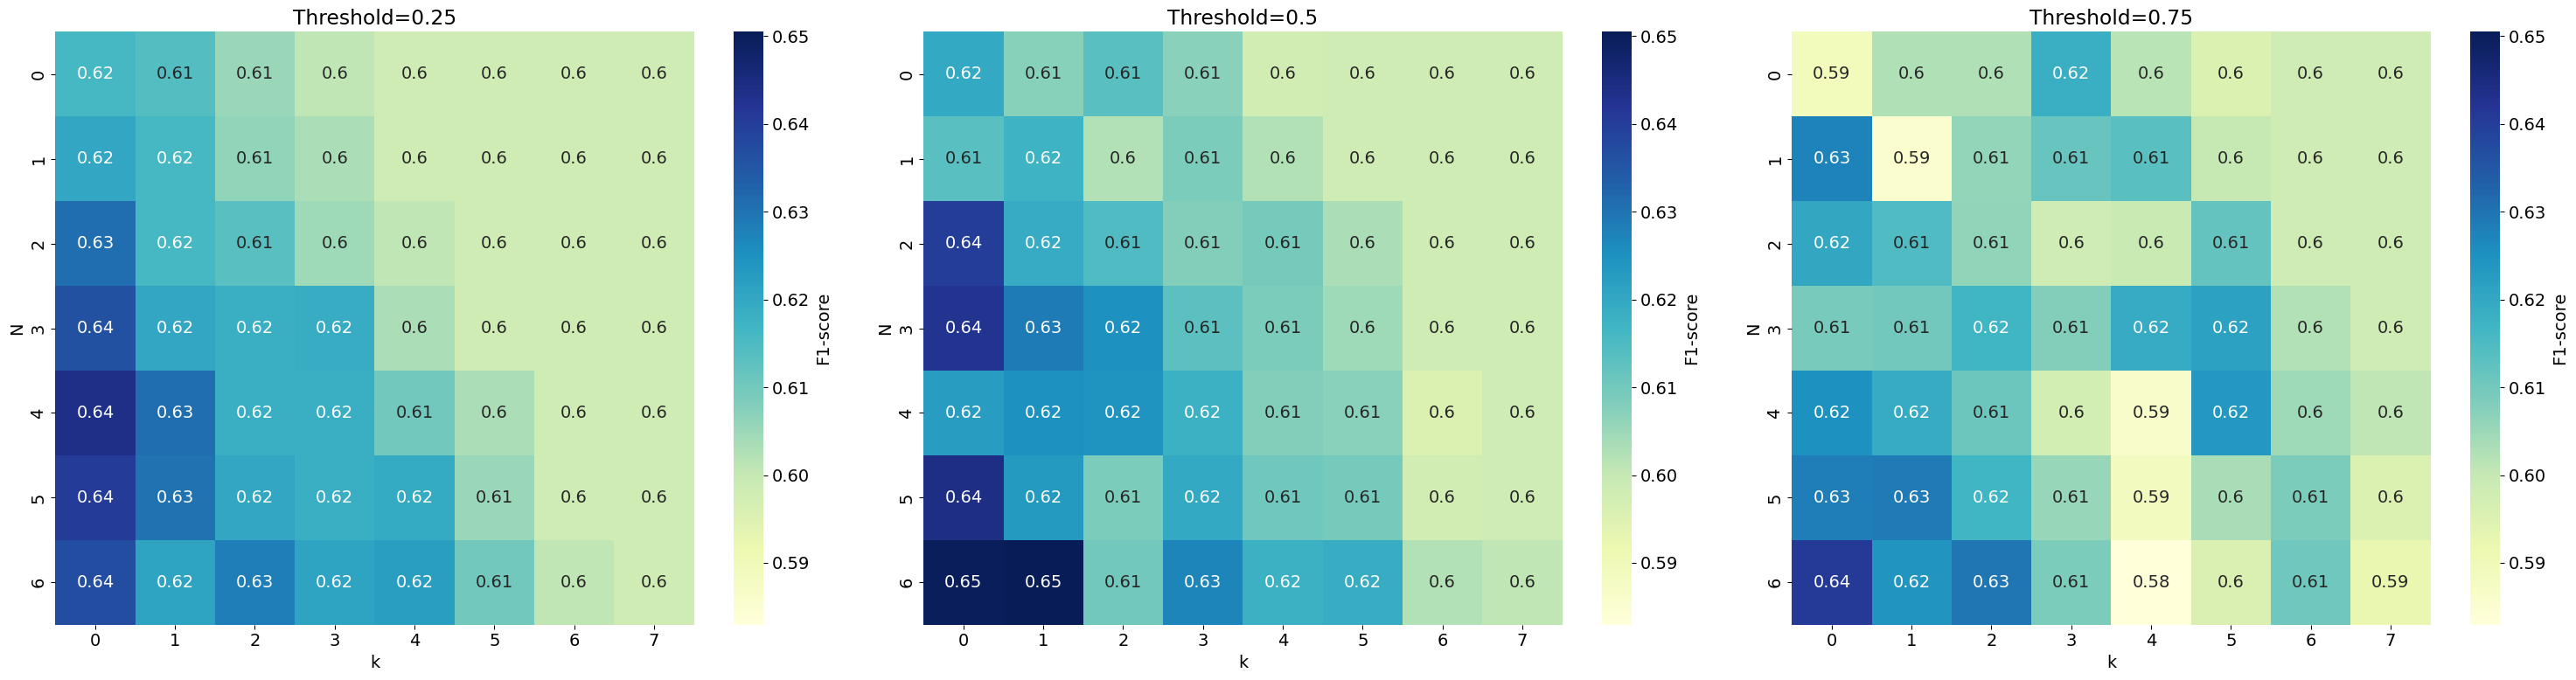

In [68]:

overall_min = global_f1_scores.min()
overall_max = global_f1_scores.max()

plt.rcParams['font.size'] = 14

n = len(th_values)

plt.figure(figsize=(n * 10, 8))

for th_index, th in enumerate(th_values):

    plt.subplot(1, n, th_index + 1)

    sns.heatmap(global_f1_scores[th_index], annot=True, cmap="YlGnBu", cbar_kws={
                'label': 'F1-score'}, vmin=overall_min, vmax=overall_max)

    plt.title(f"Threshold={th}")
    plt.xlabel('k')
    plt.ylabel('N')

plt.tight_layout()
plt.show()

## Selección óptima de parámetros de las matrices de estudio

In [23]:
# Best metrics indices

max_global_acc_index = np.argmax(global_acc_scores)
max_global_acc_th_index, max_global_acc_N_index, max_global_acc_k_index = np.unravel_index(
    max_global_acc_index, (num_th_values, num_N_values, num_k_values))

max_global_recall_index = np.argmax(global_recall_scores)
max_global_recall_th_index, max_global_recall_N_index, max_global_recall_k_index = np.unravel_index(
    max_global_recall_index, (num_th_values, num_N_values, num_k_values))

max_global_precision_index = np.argmax(global_precision_scores)
max_global_precision_th_index, max_global_precision_N_index, max_global_precision_k_index = np.unravel_index(
    max_global_precision_index, (num_th_values, num_N_values, num_k_values))

max_global_f1_index = np.argmax(global_f1_scores)
max_global_f1_th_index, max_global_f1_N_index, max_global_f1_k_index = np.unravel_index(
    max_global_f1_index, (num_th_values, num_N_values, num_k_values))

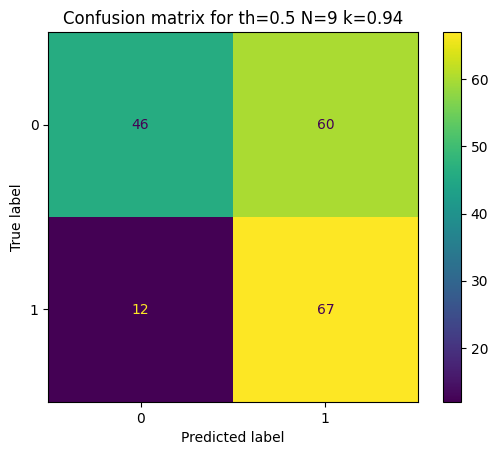

              precision    recall  f1-score   support

           0       0.79      0.43      0.56       106
           1       0.53      0.85      0.65        79

    accuracy                           0.61       185
   macro avg       0.66      0.64      0.61       185
weighted avg       0.68      0.61      0.60       185



In [24]:
th = th_values[max_global_f1_th_index]
N = N_values[max_global_f1_N_index]
k = k_values[max_global_f1_k_index]

native_veg_filename = f"predictions_N={N}_k={k}_th={th}.csv"
native_veg_poly_pred_path = paths.data_processed_dir(
    "poly_predictions", native_veg_filename)
native_veg_poly_pred = pd.read_csv(native_veg_poly_pred_path, index_col="ID")

native_veg_y_true = poly_true_values_df.loc[veg_type_mask]["label"]
native_veg_y_pred = native_veg_poly_pred.loc[veg_type_mask]["prediction"]

cm = confusion_matrix(native_veg_y_true, native_veg_y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title(f"Confusion matrix for th={th} N={N} k={k}")
plt.show()
print(classification_report(native_veg_y_true, native_veg_y_pred))

In [67]:
poly_results = poly_true_values_df.copy()
poly_true_values_df.loc[:, "prediction"] = poly_pred

In [88]:
poly_true_values_df[veg_type_mask][[
    "change_type", "label", "prediction"]].value_counts()

change_type  label  prediction
drought      0      1.0           52
logging      1      1.0           48
stable       0      0.0           35
fire         1      1.0           19
drought      0      0.0           11
fire         1      0.0            8
stable       0      1.0            8
logging      1      0.0            4
Name: count, dtype: int64

In [89]:
poly_results[veg_type_mask][["change_type", "label",
                             "prediction"]].value_counts(normalize=True)

change_type  label  prediction
drought      0      1.0           0.281081
logging      1      1.0           0.259459
stable       0      0.0           0.189189
fire         1      1.0           0.102703
drought      0      0.0           0.059459
fire         1      0.0           0.043243
stable       0      1.0           0.043243
logging      1      0.0           0.021622
Name: proportion, dtype: float64

# Grilla de desempeño y parámetros óptimos

In [41]:
f1_scores = np.zeros((num_th_values, num_N_values, num_k_values))
recall_scores = np.zeros((num_th_values, num_N_values, num_k_values))
precision_scores = np.zeros(
    (num_th_values, num_N_values, num_k_values))
acc_scores = np.zeros((num_th_values, num_N_values, num_k_values))

veg_types = ["native"]
stable_types = ["stable", "drought"]
change_types = ["logging", "fire"]

Classification report for native stable logging
Parameters th=0.5 N=9 k=0.94




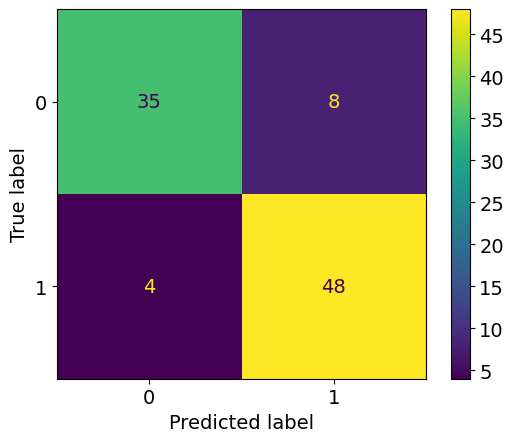



              precision    recall  f1-score   support

           0       0.90      0.81      0.85        43
           1       0.86      0.92      0.89        52

    accuracy                           0.87        95
   macro avg       0.88      0.87      0.87        95
weighted avg       0.88      0.87      0.87        95



Classification report for native stable fire
Parameters th=0.5 N=9 k=0.94




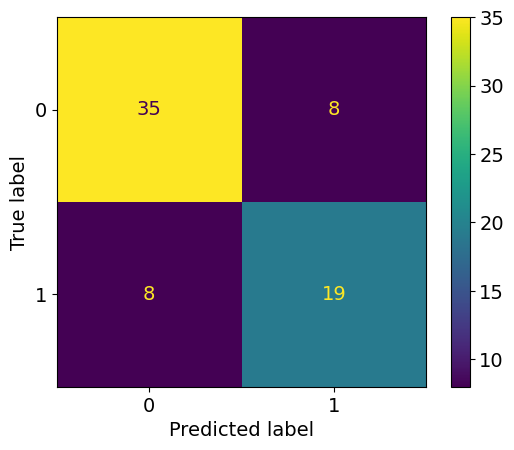



              precision    recall  f1-score   support

           0       0.81      0.81      0.81        43
           1       0.70      0.70      0.70        27

    accuracy                           0.77        70
   macro avg       0.76      0.76      0.76        70
weighted avg       0.77      0.77      0.77        70



Classification report for native drought logging
Parameters th=0.5 N=9 k=0.94




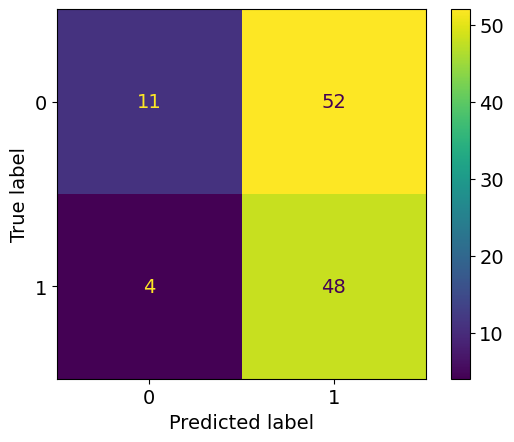



              precision    recall  f1-score   support

           0       0.73      0.17      0.28        63
           1       0.48      0.92      0.63        52

    accuracy                           0.51       115
   macro avg       0.61      0.55      0.46       115
weighted avg       0.62      0.51      0.44       115



Classification report for native drought fire
Parameters th=0.5 N=9 k=0.94




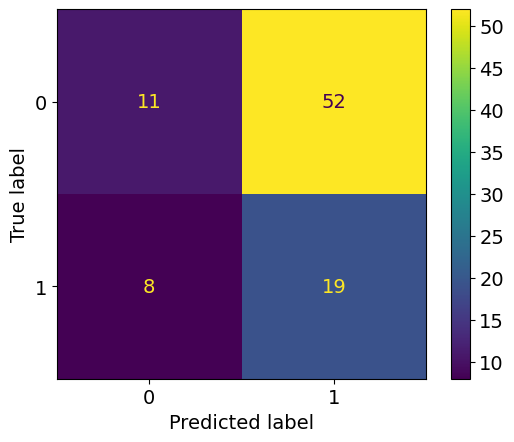



              precision    recall  f1-score   support

           0       0.58      0.17      0.27        63
           1       0.27      0.70      0.39        27

    accuracy                           0.33        90
   macro avg       0.42      0.44      0.33        90
weighted avg       0.49      0.33      0.30        90





In [42]:
metrics_list = []

for veg_type, stable_type, change_type in product(veg_types, stable_types, change_types):

    print(f"Classification report for {veg_type} {stable_type} {change_type}")
    print(f"Parameters th={th} N={N} k={k}")

    veg_type_mask = (poly_true_values_df["vegetation_type"] == veg_type)
    stable_type_mask = (poly_true_values_df["change_type"] == stable_type)
    change_type_mask = (poly_true_values_df["change_type"] == change_type)

    mask = veg_type_mask & (change_type_mask | stable_type_mask)

    th = th_values[max_global_f1_th_index]
    N = N_values[max_global_f1_N_index]
    k = k_values[max_global_f1_k_index]

    filename = f"predictions_N={N}_k={k}_th={th}.csv"
    poly_pred_path = paths.data_processed_dir("poly_predictions", filename)

    poly_pred = pd.read_csv(poly_pred_path, index_col="ID")

    sel_y_true = poly_true_values_df[mask]["label"]
    sel_y_pred = poly_pred[mask]["prediction"]

    cm = confusion_matrix(sel_y_true, sel_y_pred)

    print("\n")
    ConfusionMatrixDisplay(cm).plot()
    plt.show()

    print("\n")
    print(classification_report(sel_y_true, sel_y_pred, zero_division=0))

    metrics = {
        'Vegetation Type': veg_type,
        'Non-Change Type': stable_type,
        'Change Type': change_type,
        'Accuracy': accuracy_score(sel_y_true, sel_y_pred),
        'F1-Score': f1_score(sel_y_true, sel_y_pred),
        'Recall': recall_score(sel_y_true, sel_y_pred),
        'Precision': precision_score(sel_y_true, sel_y_pred),
    }

    metrics_list.append(metrics)

    print("\n" + "="*100 + "\n")

In [43]:
metrics_df = pd.DataFrame(metrics_list)
metrics_df

,Vegetation Type,Non-Change Type,Change Type,Accuracy,F1-Score,Recall,Precision
0,native,stable,logging,0.873684,0.888889,0.923077,0.857143
1,native,stable,fire,0.771429,0.703704,0.703704,0.703704
2,native,drought,logging,0.513043,0.631579,0.923077,0.480000
3,native,drought,fire,0.333333,0.387755,0.703704,0.267606
